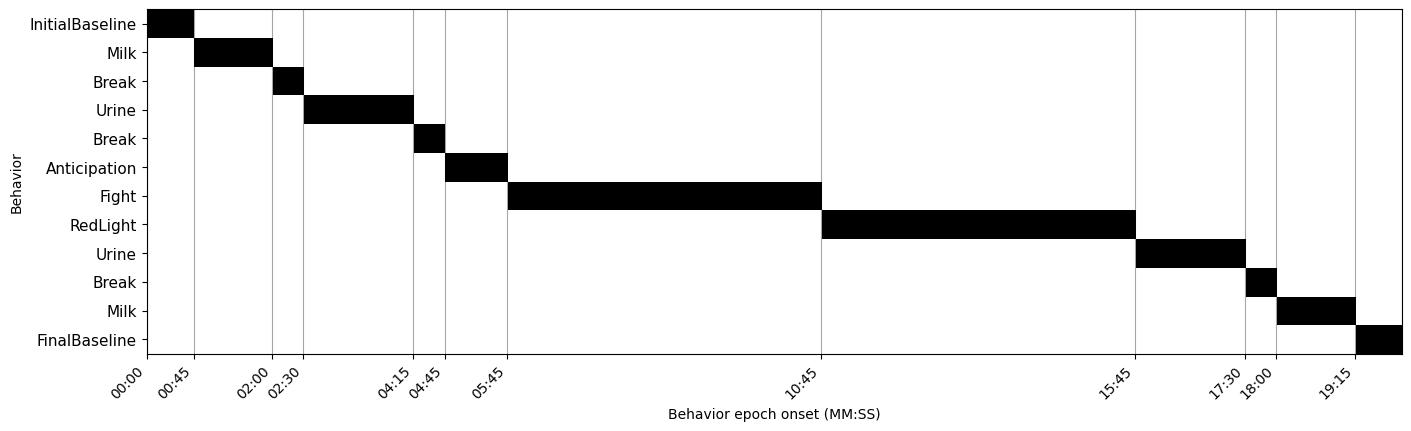

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# -------- your inputs --------
behavSeq = [
    "InitialBaseline", "Milk", "Break", "Urine", "Break",
    "Anticipation", "Fight", "RedLight", "Urine", "Break",
    "Milk", "FinalBaseline"
]
epochDurSec = [45, 75, 30, 105, 30, 60, 60 * 5, 60 * 5, 105, 30, 75, 45]
TOTAL_SEC = int(sum(epochDurSec))  # 1200

bin_size_s = 0.020  # 20 ms
downsample_factor = 1

def behavior_boundaries_seconds(epoch_durations):
    return np.concatenate([[0], np.cumsum(epoch_durations)]).astype(int)

# -------- build behavior matrix --------
ds_bin_s = bin_size_s * downsample_factor
T_ds = int(round(TOTAL_SEC / ds_bin_s))

bounds_s = behavior_boundaries_seconds(epochDurSec)  # (n_epochs+1,)
bounds_x = np.rint(bounds_s / ds_bin_s).astype(int)
bounds_x = np.clip(bounds_x, 0, T_ds)

n_beh = len(behavSeq)
B = np.zeros((n_beh, T_ds), dtype=np.float32)
for i in range(n_beh):
    x0, x1 = bounds_x[i], bounds_x[i + 1]
    if x1 > x0:
        B[i, x0:x1] = 1.0

# Plot with FinalBaseline on top
B_plot = B[::-1, :]
labels_plot = behavSeq[::-1]

# Pixel-edge coordinates (prevents blank margins)
x_left, x_right = -0.5, T_ds - 0.5
bounds_x_edges = np.clip(bounds_x.astype(float) - 0.5, x_left, x_right)

# -------- plot --------
# ---- plot (x-axis in SECONDS using extent) ----
fig_h = max(3.5, 0.35 * n_beh)
fig, ax = plt.subplots(figsize=(14, fig_h), constrained_layout=True)

ax.imshow(
    B_plot,
    aspect="auto",
    interpolation="nearest",
    origin="lower",
    cmap="Greys",
    vmin=0,
    vmax=1,
    extent=[0, TOTAL_SEC, -0.5, n_beh - 0.5]  # x is seconds now
)

ax.set_ylabel("Behavior")
ax.set_yticks(np.arange(n_beh))
ax.set_yticklabels(labels_plot, fontsize=11)

def fmt_mmss(s: int) -> str:
    m, sec = divmod(int(s), 60)
    return f"{m:02d}:{sec:02d}"

# epoch onsets in seconds
onset_s = bounds_s[:-1].astype(int)
ax.set_xticks(onset_s)
ax.set_xticklabels([fmt_mmss(s) for s in onset_s], rotation=45, ha="right")
ax.set_xlabel("Behavior epoch onset (MM:SS)")

# epoch boundaries (seconds)
for s in bounds_s:
    ax.axvline(s, color="k", linewidth=0.8, alpha=0.35)

ax.set_xlim(0, TOTAL_SEC)
plt.show()

In [ ]:
# ============================= USER SETTINGS =============================
# INPUT search root (where you have catgt_... etc.)
data_root = Path(r"J:\project_trainingAggression\Data")

# OUTPUT root (all outputs go here)
out_root = Path(r"J:\project_trainingAggression\firingRateMatrices")

bin_size_s = 0.020  # 20 ms
tau = 0.15


Agg = ["975826", "975827", "975833", "978772", "988590", "1010820", "1010823", "1010826", "1029741"]
nonAgg = ["975830", "978774", "978775", "1010819", "997839", "997840", "997841", "1029736", "1029739", "1032216"] # 978775 mounts/light attacks on the last day of training
maladaptive = ["978513", "978527", "978528", "1010832", "1013590"]

all_mice = set(Agg + nonAgg + maladaptive)

OBS_ALLOWED = {f"obs{i}" for i in range(1, 7)}  # obs1..obs6
LABELS_GOOD = {"good"}  # change to {"good","mua"} if you want to include MUA too

# ---- Behavior timeline (fixed 1200 s total) ----
behavSeq = [
    "InitialBaseline", "Milk", "Break", "Urine", "Break",
    "Anticipation", "Fight", "RedLight", "Urine", "Break",
    "Milk", "FinalBaseline"
]
epochDurSec = [45, 75, 30, 105, 30, 60, 60 * 5, 60 * 5, 105, 30, 75, 45]
TOTAL_SEC = int(sum(epochDurSec))  # 1200


# ============================= HELPERS ===================================
def find_mouse_id(path: Path, ids: set[str]) -> str | None:
    s = str(path)
    for mid in ids:
        if re.search(rf"(?<!\d){re.escape(mid)}(?!\d)", s):
            return mid
    return None


def find_obs_id(path: Path) -> str | None:
    m = re.search(r"(?i)(obs[1-6])", str(path))
    return m.group(1).lower() if m else None


def group_label_folder(mid: str) -> str:
    """
    Output top-level group folder name.
    """
    if mid in Agg:
        return "Aggressor"
    if mid in nonAgg:
        return "NonAggressor"
    if mid in maladaptive:
        return "Maladaptive"
    return "Unknown"


def load_good_cluster_ids_from_auto(auto_dir: Path, good_labels=LABELS_GOOD) -> np.ndarray:
    """
    Read selected clusters from cluster_group.tsv or cluster_info.tsv in autoForNeuroConcat.
    Uses the 'group' column (e.g., good/mua/noise). No KSLabel fallback.
    """
    cg = auto_dir / "cluster_group.tsv"
    ci = auto_dir / "cluster_info.tsv"

    for tsv in (cg, ci):
        if not tsv.exists():
            continue
        df = pd.read_csv(tsv, sep="\t")
        if {"cluster_id", "group"}.issubset(df.columns):
            grp = df["group"].astype("string").str.strip().str.lower()
            good = df.loc[grp.isin(good_labels), "cluster_id"].to_numpy(np.int64)
            return np.unique(good)

    return np.array([], dtype=np.int64)


def infer_imec_from_name(name: str) -> str | None:
    """
    Return 'imec0'/'imec1'/'imec2' if present in a string.
    """
    s = name.lower()
    if "imec0" in s:
        return "imec0"
    if "imec1" in s:
        return "imec1"
    if "imec2" in s:
        return "imec2"
    return None


def infer_probe_label(path: Path) -> str:
    """
    Prefer using imec keyword found anywhere in the path.
    """
    imec = infer_imec_from_name(str(path))
    return imec if imec else "imec?"


def find_catgt_dir(path: Path) -> Path | None:
    """
    Return the Path object corresponding to the catgt_* directory that contains this path.
    """
    for p in path.parents:
        if re.search(r"^catgt_", p.name, flags=re.IGNORECASE):
            return p
    return None


def get_sorter_output_dir(auto_dir: Path) -> Path:
    """
    In your layout:
      .../sorter_output/autoForNeuroConcat
    so spike files live in auto_dir.parent (sorter_output)
    """
    return auto_dir.parent


def load_spike_seconds_aligned(sorter_dir: Path, imec: str) -> np.ndarray:
    """
    Load the TPrime-aligned spike times in seconds from sorter_output:
      spike_seconds_imec0_adj.npy  (or imec1/imec2)
    """
    f = sorter_dir / f"spike_seconds_{imec}_adj.npy"
    if not f.exists():
        raise FileNotFoundError(f"Missing {f.name} in {sorter_dir}")
    x = np.load(f)
    return x.astype(np.float64)


def load_spike_clusters(sorter_dir: Path) -> np.ndarray:
    f = sorter_dir / "spike_clusters.npy"
    if not f.exists():
        raise FileNotFoundError(f"Missing spike_clusters.npy in {sorter_dir}")
    return np.load(f).astype(np.int64)


def make_fixed_bin_edges(total_sec: int, bin_size_s: float) -> np.ndarray:
    """
    Exact fixed-length bins from 0..total_sec.
    For 1200 s and 20 ms, n_bins = 60000.
    """
    n_bins = int(round(total_sec / bin_size_s))
    return np.linspace(0.0, float(total_sec), n_bins + 1, dtype=np.float64)


def behavior_boundaries_seconds(epoch_durations: list[int]) -> np.ndarray:
    return np.concatenate([[0], np.cumsum(epoch_durations)]).astype(int)


def downsample_time_axis_mean(X: np.ndarray, factor: int) -> np.ndarray:
    """
    Mean-pool downsample along time axis for plotting.
    X: (units, time)
    """
    if factor <= 1:
        return X
    T = X.shape[1]
    T2 = (T // factor) * factor
    if T2 <= 0:
        return X
    return X[:, :T2].reshape(X.shape[0], T2 // factor, factor).mean(axis=2)


def zscore_rows(X: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True)
    return (X - mu) / (sd + eps)


# ============================= BUILD FR MATRIX ============================
def build_fr_matrix_fixed_1200s_tprime(
    auto_probe_dirs: list[Path],
    bin_size_s: float,
    total_sec: int
) -> dict:
    """
    Build fixed-length FR matrix (units x time) across probes for a session.
    - Uses GOOD cluster IDs from autoForNeuroConcat (per probe directory)
    - Uses spike_clusters.npy from sorter_output (shared)
    - Uses spike_seconds_imec{0,1,2}_adj.npy from sorter_output (TPrime-aligned seconds)

    IMPORTANT ASSUMPTION:
      spike_clusters.npy indexes clusters for spikes within a given probe's sorter_output
      and the spike_seconds_{imec}_adj.npy corresponds to the same spikes for that probe.
    """
    bin_edges_s = make_fixed_bin_edges(total_sec, bin_size_s)
    n_bins = bin_edges_s.size - 1

    fr_rows: list[np.ndarray] = []
    unit_keys: list[str] = []

    # For saving debug metadata
    used_sorter_dirs = []
    used_auto_dirs = []
    used_imecs = []

    for auto_dir in auto_probe_dirs:
        sorter_dir = get_sorter_output_dir(auto_dir)
        imec = infer_probe_label(auto_dir)
        if imec not in {"imec0", "imec1", "imec2"}:
            raise RuntimeError(f"Could not infer imec0/1/2 from path: {auto_dir}")

        good_ids = load_good_cluster_ids_from_auto(auto_dir)
        if good_ids.size == 0:
            continue

        spike_seconds = load_spike_seconds_aligned(sorter_dir, imec)  # aligned seconds
        spike_clusters = load_spike_clusters(sorter_dir)

        if spike_seconds.shape[0] != spike_clusters.shape[0]:
            raise RuntimeError(
                f"Spike seconds and spike_clusters length mismatch in {sorter_dir} ({imec}): "
                f"{spike_seconds.shape[0]} vs {spike_clusters.shape[0]}"
            )

        # keep GOOD clusters
        good_mask = np.isin(spike_clusters, good_ids)
        if not np.any(good_mask):
            continue

        t_s = spike_seconds[good_mask]
        c = spike_clusters[good_mask]

        # fixed 0..total_sec window
        keep = (t_s >= 0.0) & (t_s < float(total_sec))
        if not np.any(keep):
            continue
        t_s = t_s[keep]
        c = c[keep]

        # bin index
        bin_idx = np.floor(t_s / bin_size_s).astype(np.int64)
        bin_idx = np.clip(bin_idx, 0, n_bins - 1)

        # per-cluster row
        for cid in np.unique(c):
            m = (c == cid)
            if not np.any(m):
                continue
            counts = np.bincount(bin_idx[m], minlength=n_bins).astype(np.float32)
            fr_hz = counts / float(bin_size_s)

            fr_rows.append(fr_hz)
            unit_keys.append(f"{imec}:{int(cid)}")

        used_sorter_dirs.append(str(sorter_dir))
        used_auto_dirs.append(str(auto_dir))
        used_imecs.append(imec)

    if len(fr_rows) == 0:
        raise RuntimeError("No units produced any binned counts within the fixed 1200 s window.")

    FR = np.stack(fr_rows, axis=0).astype(np.float32)

    return {
        "FR": FR,
        "unit_keys": np.array(unit_keys, dtype=object),
        "bin_edges_s": bin_edges_s,
        "bin_size_s": float(bin_size_s),
        "total_sec": int(total_sec),
        "sorter_dirs_used": np.array(used_sorter_dirs, dtype=object),
        "auto_probe_dirs_used": np.array(used_auto_dirs, dtype=object),
        "imecs_used": np.array(used_imecs, dtype=object),
    }


# ============================= HEATMAP SAVE ===============================
def save_heatmap_with_behavior(
    FR: np.ndarray,
    out_png: Path,
    bin_size_s: float,
    behav_seq: list[str],
    epoch_dur_s: list[int],
    *,
    downsample_factor: int = 10,
    zscore_for_display: bool = True,
    fixed_zlim: tuple[float, float] | None = (-1.0, 1.0),
    clip_to_zlim: bool = True,
    fig_w: float = 26.0,
    cmap_heat: str = "bwr",   # <-- blue(-) -> white(0) -> red(+)
):
    import numpy as np
    import matplotlib.pyplot as plt

    # ---------- heatmap data (DISPLAY ONLY) ----------

    X = FR.astype(np.float64)     # Hz

    # match your clustering choice, e.g. tau=0.2     
    dt = bin_size_s

    wc = float(np.clip(dt / tau, 1e-3, 0.999))
    b, a = butter(1, wc, btype="low", analog=False, output="ba")
    X = filtfilt(b, a, X, axis=1)

    X = zscore_rows(X)


    Xd = downsample_time_axis_mean(X, downsample_factor)
    ds_bin_s = bin_size_s * downsample_factor
    n_units, T_ds = Xd.shape

    if fixed_zlim is not None and clip_to_zlim:
        Xd = np.clip(Xd, fixed_zlim[0], fixed_zlim[1])

    # ---------- behavior matrix ----------
    bounds_s = behavior_boundaries_seconds(epoch_dur_s)  # [0..TOTAL]
    bounds_x = np.rint(bounds_s / ds_bin_s).astype(int)
    bounds_x = np.clip(bounds_x, 0, T_ds)

    n_beh = len(behav_seq)
    B = np.zeros((n_beh, T_ds), dtype=np.float32)
    for i in range(n_beh):
        x0, x1 = bounds_x[i], bounds_x[i + 1]
        if x1 > x0:
            B[i, x0:x1] = 1.0

    # match your example ordering (FinalBaseline on top)
    B_plot = B[::-1, :]
    behav_labels_plot = behav_seq[::-1]

    # ---------- pixel-edge coordinates to avoid blank right margin ----------
    x_left = -0.5
    x_right = T_ds - 0.5

    # draw boundaries at pixel edges (bin edge at x0 is between columns x0-1 and x0)
    bounds_x_edges = (bounds_x.astype(np.float64) - 0.5)
    bounds_x_edges = np.clip(bounds_x_edges, x_left, x_right)

    # ---------- figure ----------
    fig_h = max(6.0, min(16.0, 0.02 * n_units + 7.0))
    fig, (ax_beh, ax) = plt.subplots(
        2, 1, figsize=(fig_w, fig_h),
        sharex=True,
        gridspec_kw={"height_ratios": [1.6, 10.0], "hspace": 0.05},
        constrained_layout=True
    )

    # Behavior panel
    ax_beh.imshow(
        B_plot, aspect="auto", interpolation="nearest", origin="lower",
        cmap="Greys", vmin=0, vmax=1
    )
    ax_beh.set_ylabel("Behavior")
    ax_beh.set_yticks(np.arange(n_beh))
    ax_beh.set_yticklabels(behav_labels_plot, fontsize=11)
    ax_beh.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

    for bx in bounds_x_edges:
        ax_beh.axvline(bx, color="k", linewidth=0.6, alpha=0.35)

    # Heatmap panel
    im_kwargs = dict(
        aspect="auto",
        interpolation="nearest",
        origin="lower",
        cmap=cmap_heat,
    )
    if fixed_zlim is not None:
        im_kwargs.update(vmin=fixed_zlim[0], vmax=fixed_zlim[1])

    im = ax.imshow(Xd, **im_kwargs)
    ax.set_ylabel("Neurons")
    ax.set_xlabel(f"Time (downsampled; {ds_bin_s*1000:.0f} ms per column)")

    for bx in bounds_x_edges:
        ax.axvline(bx, color="k", linewidth=0.6, alpha=0.25)

    # Apply exact x-limits to both panels (kills the empty right strip)
    ax.set_xlim(x_left, x_right)

    cb = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.01)
    cb.set_label("Z-scored (display only)")

    out_png.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_png, dpi=200)
    plt.close(fig)




# ============================= DISCOVER SESSIONS ==========================
# Anchor on autoForNeuroConcat, group sessions by the catgt_* directory PATH.
auto_dirs = sorted([p for p in data_root.rglob("autoForNeuroConcat") if p.is_dir()])

session_to_auto_probe_dirs: dict[str, list[Path]] = defaultdict(list)
session_meta: dict[str, dict] = {}

for auto_dir in auto_dirs:
    mid = find_mouse_id(auto_dir, all_mice)
    if mid is None:
        continue

    obs = find_obs_id(auto_dir)
    if obs is None or obs not in OBS_ALLOWED:
        continue

    catgt_dir = find_catgt_dir(auto_dir)
    if catgt_dir is None:
        continue

    session_key = str(catgt_dir.resolve())  # unique per session even if names repeat elsewhere
    session_to_auto_probe_dirs[session_key].append(auto_dir)
    session_meta.setdefault(session_key, {
        "mouse": mid,
        "obs": obs,
        "group_folder": group_label_folder(mid),
        "catgt_dir": str(catgt_dir),
        "catgt_name": catgt_dir.name,
    })

print(f"Found {len(session_to_auto_probe_dirs)} sessions with at least one probe directory.")


# ============================= BUILD + SAVE ===============================
out_root.mkdir(parents=True, exist_ok=True)

n_saved = 0
n_skipped = 0

for session_key, auto_probe_dirs in session_to_auto_probe_dirs.items():
    meta = session_meta[session_key]
    mid = meta["mouse"]
    obs = meta["obs"]
    group_folder = meta["group_folder"]
    catgt_name = meta["catgt_name"]
    catgt_dir = meta["catgt_dir"]

    # Output structure:
    # out_root / {GroupFolder} / {mouseID} / files...
    group_out_dir = out_root / group_folder
    mouse_out_dir = group_out_dir / str(mid)
    mouse_out_dir.mkdir(parents=True, exist_ok=True)

    base = f"{catgt_name}_fr20ms_1200s"
    out_mat = mouse_out_dir / f"{base}.mat"
    out_png = mouse_out_dir / f"{base}_heatmap.png"

    try:
        mat = build_fr_matrix_fixed_1200s_tprime(
            auto_probe_dirs=auto_probe_dirs,
            bin_size_s=bin_size_s,
            total_sec=TOTAL_SEC,
        )

        mat.update({
            "mouse_id": str(mid),
            "group_folder": str(group_folder),
            "obs": str(obs),
            "catgt_name": str(catgt_name),
            "catgt_dir": str(catgt_dir),
            "behavSeq": np.array(behavSeq, dtype=object),
            "epochDurSec": np.array(epochDurSec, dtype=np.int32),
            "TOTAL_SEC": int(TOTAL_SEC),
        })

        savemat(out_mat, mat, do_compression=True)

        save_heatmap_with_behavior(
            FR=mat["FR"],
            out_png=out_png,
            bin_size_s=bin_size_s,
            behav_seq=behavSeq,
            epoch_dur_s=epochDurSec,
            downsample_factor=1, 
            zscore_for_display=True
        )

        n_saved += 1
        print(f"[OK] {group_folder} | mouse={mid} obs={obs} | MAT={out_mat.name} | PNG={out_png.name} | FR={mat['FR'].shape}")

    except Exception as e:
        n_skipped += 1
        print(f"[SKIP] {catgt_name} (mouse={mid}, obs={obs}) -> {e}")

print(f"\nDone. Saved {n_saved} sessions. Skipped {n_skipped} sessions.")
print(f"Output root: {out_root}")


Found 108 sessions with at least one probe directory.
[OK] Aggressor | mouse=975826 obs=obs1 | MAT=catgt_20250817_m975826_obs1_g0_fr20ms_1200s.mat | PNG=catgt_20250817_m975826_obs1_g0_fr20ms_1200s_heatmap.png | FR=(287, 60000)
[OK] Aggressor | mouse=975826 obs=obs2 | MAT=catgt_20250818_m975826_obs2_g0_fr20ms_1200s.mat | PNG=catgt_20250818_m975826_obs2_g0_fr20ms_1200s_heatmap.png | FR=(548, 60000)
[OK] Aggressor | mouse=975826 obs=obs3 | MAT=catgt_20250818_m975826_obs3_g0_fr20ms_1200s.mat | PNG=catgt_20250818_m975826_obs3_g0_fr20ms_1200s_heatmap.png | FR=(232, 60000)
[OK] Aggressor | mouse=975826 obs=obs4 | MAT=catgt_20250818_m975826_obs4_g0_fr20ms_1200s.mat | PNG=catgt_20250818_m975826_obs4_g0_fr20ms_1200s_heatmap.png | FR=(383, 60000)
[OK] Aggressor | mouse=975826 obs=obs5 | MAT=catgt_20250818_m975826_obs5_g0_fr20ms_1200s.mat | PNG=catgt_20250818_m975826_obs5_g0_fr20ms_1200s_heatmap.png | FR=(307, 60000)
[OK] Aggressor | mouse=975826 obs=obs6 | MAT=catgt_20250818_m975826_obs6_g0_fr20m